This notebook is to demonstrate the working of pretrained Detectree2 model with DataLoaders from the chipping logic developed for tree-detection-framework
--

Make sure you're running this notebook in the same folder where `chip_ortho.py` exists

In [27]:
import os

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation.coco_evaluation import instances_to_coco_json

from chip_ortho import chip_orthomosaics  # import from tree-detection-framework code
from torchgeo.datasets import unbind_samples
import matplotlib.pyplot as plt

Setup config expected by Detectree2
--
setup_cfg() is a function from `detectree2` library

In [2]:
def setup_cfg(
    base_model: str = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
    trains=("trees_train",),
    tests=("trees_val",),
    update_model=None,
    workers=2,
    ims_per_batch=2,
    gamma=0.1,
    backbone_freeze=3,
    warm_iter=120,
    momentum=0.9,
    batch_size_per_im=1024,
    base_lr=0.0003389,
    weight_decay=0.001,
    max_iter=1000,
    num_classes=1,
    eval_period=100,
    out_dir="./train_outputs",
    resize=True,
):
    """Set up config object # noqa: D417.

    Args:
        base_model: base pre-trained model from detectron2 model_zoo
        trains: names of registered data to use for training
        tests: names of registered data to use for evaluating models
        update_model: updated pre-trained model from detectree2 model_garden
        workers: number of workers for dataloader
        ims_per_batch: number of images per batch
        gamma: gamma for learning rate scheduler
        backbone_freeze: backbone layer to freeze
        warm_iter: number of iterations for warmup
        momentum: momentum for optimizer
        batch_size_per_im: batch size per image
        base_lr: base learning rate
        weight_decay: weight decay for optimizer
        max_iter: maximum number of iterations
        num_classes: number of classes
        eval_period: number of iterations between evaluations
        out_dir: directory to save outputs
    """
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(base_model))
    cfg.DATASETS.TRAIN = trains
    cfg.DATASETS.TEST = tests
    cfg.DATALOADER.NUM_WORKERS = workers
    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.GAMMA = gamma
    cfg.MODEL.BACKBONE.FREEZE_AT = backbone_freeze
    cfg.SOLVER.WARMUP_ITERS = warm_iter
    cfg.SOLVER.MOMENTUM = momentum
    cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = batch_size_per_im
    cfg.SOLVER.WEIGHT_DECAY = weight_decay
    cfg.SOLVER.BASE_LR = base_lr
    cfg.OUTPUT_DIR = out_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    if update_model is not None:
        cfg.MODEL.WEIGHTS = update_model
    else:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_model)

    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.TEST.EVAL_PERIOD = eval_period
    cfg.RESIZE = resize
    cfg.INPUT.MIN_SIZE_TRAIN = 1000
    return cfg

In [30]:
trained_model = "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"  # Load pretrained weights from local
cfg = setup_cfg(update_model=trained_model)
predictor = DefaultPredictor(cfg)

2024-10-10 17:23:05,196 - INFO - [DetectionCheckpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
2024-10-10 17:23:05,197 - INFO - [Checkpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

In [31]:
raster_dir = "/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho"  # Path to raster image

In [9]:
dataloader = chip_orthomosaics(
    raster_path=raster_dir, size=50, stride=40, res=0.2, use_units_meters=True
)

2024-10-10 17:09:19,821 - INFO - Units = Units.CRS
2024-10-10 17:09:19,823 - INFO - Stride = 40


`dataloader` has the input raster image chipped into tiles

In [11]:
len(dataloader)  # number of tiles

64

In [14]:
dataloader.sampler.res  # verify that tiles are in the specified resolution

0.2

Visulaize the tiled data
--
Plot 5 tiles

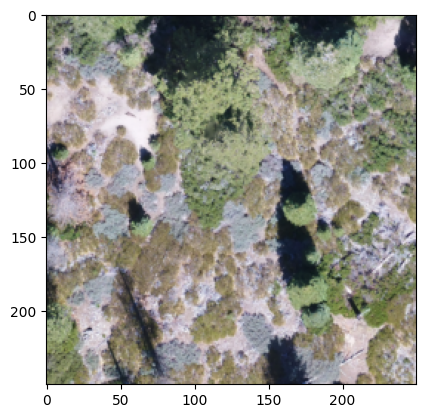

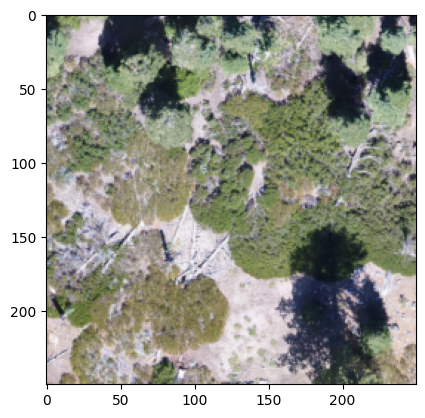

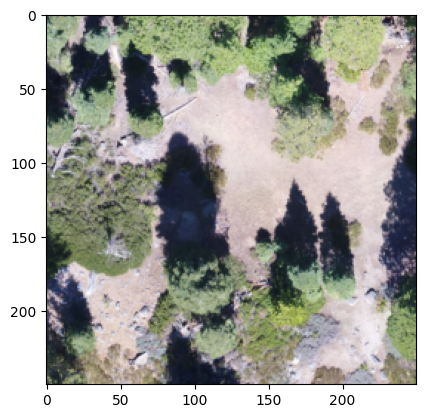

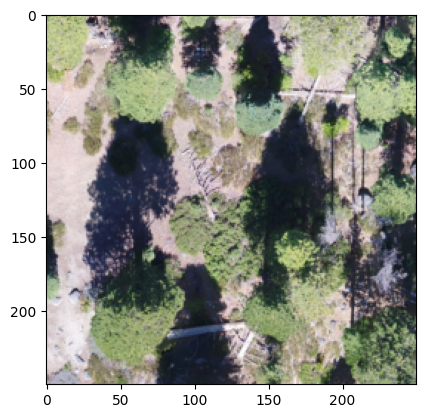

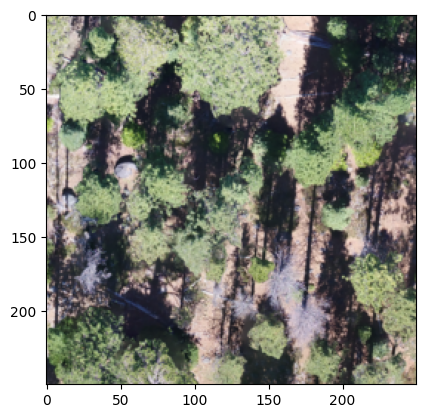

In [19]:
def plot_tiles(sample):
    image = sample.permute(1, 2, 0)
    image = image.byte().numpy()
    fig, ax = plt.subplots()
    ax.imshow(image)
    return fig


for i, tile in enumerate(dataloader):
    if i < 5:
        sample = unbind_samples(tile)[0]
        plot_tiles(sample["image"])

Predict
--

In the future we will call the predict method defined by the `LightningDetector` class. But the below function does the predictions for now in limited steps.

In [22]:
def predict_tiles(dataloader):

    for i, tile in enumerate(dataloader):
        sample = unbind_samples(tile)[0]

        image = sample["image"].permute(1, 2, 0).byte().numpy()
        outputs = predictor(image[:, :, :3])

    return outputs

save predictions in `outputs`

In [ ]:
outputs = predict_tiles(dataloader)

The predictions are currently returned by `detectree2` as an `Instances` object.

In [26]:
instance_0 = outputs["instances"][0]
instance_0

Instances(num_instances=1, image_height=250, image_width=250, fields=[pred_boxes: Boxes(tensor([[6.5508e-02, 1.5154e+02, 5.0887e+01, 2.1106e+02]], device='cuda:0')), scores: tensor([0.8880], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])

The below function gives the predictions as a Run-length Encoded (RLE) value
--

In [29]:
evaluation = instances_to_coco_json(outputs["instances"].to("cpu"), 0)
evaluation[0]

{'image_id': 0,
 'category_id': 0,
 'bbox': [0.06550788879394531,
  151.5447235107422,
  50.82118225097656,
  59.51695251464844],
 'score': 0.8880224227905273,
 'segmentation': {'size': [250, 250],
  'counts': 'U5j0m66M1N3M2O2M2N2O1N2O1N101N2O1O001O1O00010O0001O00001O000O2O000O1O001O1O1O1O1O1O2N1O2O0O2N3M2N3M4K5F[e`1'}}

Originally, `detectree2` requires the tiles data to be saved to disk. The tiles are then read from disk to make predictions which requires a lot of additional steps. 

This is the original prediction fuction from `detectree2`:
--

In [ ]:
def predict_on_data(
    directory: str = "./",
    out_folder: str = "predictions",
    predictor=DefaultPredictor,
    eval=False,
    save: bool = True,
    num_predictions=0,
):
    """Make predictions on tiled data.

    Predicts crowns for all png images present in a directory and outputs masks as jsons.
    """

    # pred_dir = os.path.join(directory, out_folder)
    pred_dir = (
        "/ofo-share/scratch-amritha/tree-detection-framework-scratch/dtree2_predictions"
    )

    Path(pred_dir).mkdir(parents=True, exist_ok=True)

    if eval:
        dataset_dicts = get_tree_dicts(directory)
    else:
        dataset_dicts = get_filenames(directory)

    total_files = len(dataset_dicts)

    # Works out if all items in folder should be predicted on
    if num_predictions == 0:
        num_to_pred = len(dataset_dicts)
    else:
        num_to_pred = num_predictions

    print(f"Predicting {num_to_pred} files")

    for i, d in enumerate(dataset_dicts[:num_to_pred], start=1):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)

        # Creating the file name of the output file
        file_name_path = d["file_name"]
        # Strips off all slashes so just final file name left
        file_name = os.path.basename(os.path.normpath(file_name_path))
        file_name = file_name.replace("png", "json")
        output_file = os.path.join(pred_dir, f"Prediction_{file_name}")
        # print(output_file)

        if save:
            # Converting the predictions to json files and saving them in the
            # specfied output file.
            evaluations = instances_to_coco_json(
                outputs["instances"].to("cpu"), d["file_name"]
            )
            with open(output_file, "w") as dest:
                json.dump(evaluations, dest)

        if i % 50 == 0:
            print(f"Predicted {i} files of {total_files}")